In [0]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import cv2 as cv
import tensorflow as tf
from keras import backend
from keras.models import *
from keras.metrics import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
ap = []
lat = []
textr = open("location_train.txt").read()
files = textr.split("\n")

for file in files:
  if("ap." in file.lower()):
    ap.append(file)

  elif("lat." in file.lower()):
    lat.append(file)

In [0]:
def status(file):
  if("Damaged" in file):
    return 1
  elif("Normal" in file):
    return 0

In [0]:
X = []; y = []
for i in range(len(ap)):
  X.append((ap[i],lat[i]))
  y.append(status(ap[i]))
X = np.array(X)
y = np.array(y)

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size = 0.2, random_state=42)

In [0]:
X_train_ap = X_train[:,0].reshape(-1,1)
X_valid_ap = X_valid[:,0].reshape(-1,1)
X_train_lat = X_train[:,1].reshape(-1,1)
X_valid_lat = X_valid[:,1].reshape(-1,1)
y_train = y_train.reshape(-1,1)
y_valid = y_valid.reshape(-1,1)

In [0]:
def resized(img_path):
  img = cv.imread(img_path)
  img = cv.resize(img,(128,128))
  img = img/255.0
  return img

In [0]:
def image_generator(X,y, batch_size):
  while True:
    batch  = np.random.choice(X[0].shape[0],size = batch_size)
    batch_input1  = []
    batch_input2 = []
    batch_output = []
    
    for i in batch:
      output = y[i]
      input1 = resized(X[0][i][0])
      input2 = resized(X[1][i][0])

      batch_input1  += [input1]
      batch_input2 += [input2]
      batch_output += [output]

    batch_x1 = np.array(batch_input1)
    batch_x2 = np.array(batch_input2)
    batch_y = np.array(batch_output)
    
    yield ([batch_x1,batch_x2], batch_y)

In [0]:
def layer_stack(n_filters,inpt,dropout):
  model = Conv2D(n_filters, (3, 3), padding='same')(inpt)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  #model = Dropout(rate = dropout)(model)
  return model

def conv_layers(input_img,shape,n_filters):
  model = Conv2D(n_filters, (3, 3), padding='same',input_shape=shape)(input_img)
  model = LeakyReLU(alpha=0.1)(model)
  model = MaxPooling2D((2, 2),padding='same')(model)
  #model = Dropout(rate = 0.25)(model)
  model = layer_stack(n_filters*2,model,0.25)
  model = layer_stack(n_filters*2*2,model,0.25)
  return model

In [0]:
shape = (128,128,3)
n_filters = 16
ap_input = Input(shape=shape)
ap_model = conv_layers(ap_input,shape=shape,n_filters = n_filters)

lat_input = Input(shape=shape)
lat_model = conv_layers(lat_input,shape=shape,n_filters = n_filters)

conv = concatenate([ap_model,lat_model])
conv = Flatten()(conv)

dense = Dense(512)(conv)
dense = LeakyReLU(alpha=0.1)(dense)
#dense = Dropout(0.25)(dense)

output = Dense(1, activation='sigmoid')(dense)
model = Model(inputs=[ap_input,lat_input], outputs=[output])
model.compile(loss="binary_crossentropy",optimizer=Adam(),metrics=['accuracy'])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 128, 128, 16) 448         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 16) 448         input_4[0][0]                    
____________________________________________________________________________________________

In [0]:
checkpoint1 = ModelCheckpoint(filepath="weights.hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
results = model.fit_generator(image_generator([X_train_ap,X_train_lat],y_train,10),steps_per_epoch=50, epochs=30,validation_data=image_generator([X_valid_ap,X_valid_lat],y_valid,10),validation_steps=12,callbacks = [checkpoint1])




Epoch 1/30





50/50 [==============================] - 740s 15s/step - loss: 0.8260 - acc: 0.5680 - val_loss: 0.5336 - val_acc: 0.7250

Epoch 00001: val_acc improved from -inf to 0.72500, saving model to weights.hdf5
Epoch 2/30
50/50 [==============================] - 294s 6s/step - loss: 0.4970 - acc: 0.7700 - val_loss: 0.5283 - val_acc: 0.7417

Epoch 00002: val_acc improved from 0.72500 to 0.74167, saving model to weights.hdf5
Epoch 3/30
50/50 [==============================] - 165s 3s/step - loss: 0.4242 - acc: 0.8100 - val_loss: 0.5560 - val_acc: 0.7250

Epoch 00003: val_acc did not improve from 0.74167
Epoch 4/30
50/50 [==============================] - 97s 2s/step - loss: 0.3582 - acc: 0.8340 - val_loss: 0.5310 - val_acc: 0.7167

Epoch 00004: val_acc did not improve from 0.74167
Epoch 5/30
50/50 [==============================] - 88s 2s/step - loss: 0.3067 - acc: 0.8700 - val_loss: 0.6737 - val_acc: 0.7417

Epoch 00005: val_acc did not improve from 0.74167
Epoch 6/30
50/50 [

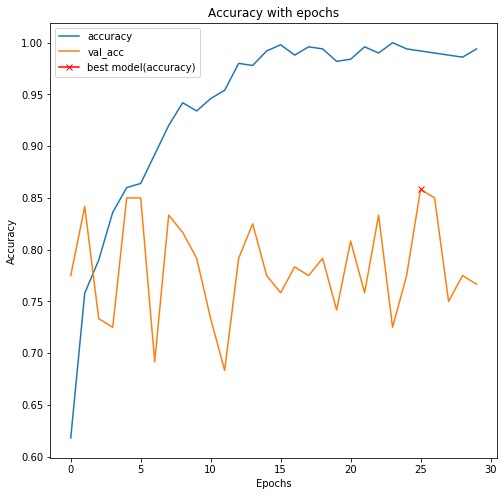

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Accuracy with epochs")
plt.plot(results.history['acc'], label="accuracy")
plt.plot(results.history["val_acc"], label="val_acc")
plt.plot(np.argmax(results.history["val_acc"]), np.max(results.history["val_acc"]), marker="x", color="r", label="best model(accuracy)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [0]:
model.load_weights('weights.hdf5')

In [0]:
files = []
for d,_,filename in os.walk("/content/drive/My Drive/TestData"):
  for f in filename:        
    files.append(os.path.join(d,f))

In [0]:
files = sorted(files)
count = 0
d = {}
for f in files:
  num = int(f[f.find("(")+1:f.find(")")])
  count+=1
  if(count%2 != 0):
    d[num] = [f]
  else:
    d[num].append(f)

In [0]:
def collapse(prob):
  if(prob>=0.5):
    return 1
  else:
    return 0

for i in d.keys():
  d[i] = collapse(model.predict([[resized(d[i][0])],[resized(d[i][1])]]))

In [0]:
dict2 = {}
for i in d.keys():
  dict2[str(i)] = str(d[i])


import pickle
pickle_out = open("classification_correct.pickle","wb")
pickle.dump(dict2, pickle_out)
pickle_out.close()